In [ ]:
# run with 'tf-gpu' environment

In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from keras.utils import to_categorical

In [5]:
import keras

In [6]:
import os
import glob

In [7]:
import h5py
import json

In [ ]:
def prepare_image_label(img_path,lbl_vsl_path,lbl_od_path,lbl_msk_path,plot_before):
    # 1) read images
    img = cv2.imread(img_path) #BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #RGB
    lbl_vsl = cv2.imread(lbl_vsl_path,0)
    lbl_od = cv2.imread(lbl_od_path,0)
    lbl_msk = cv2.imread(lbl_msk_path,0)
    if len(np.unique(lbl_vsl)!=2):
      # grayImage = cv2.cvtColor(lbl_vsl, cv2.COLOR_BGR2GRAY)
      (thresh, lbl_vsl) = cv2.threshold(lbl_vsl, 127, 255, cv2.THRESH_BINARY)
    # print(lbl_vsl.shape,lbl_od.shape,lbl_msk.shape)
    # print(len(np.unique(lbl_vsl)),len(np.unique(lbl_od)),len(np.unique(lbl_msk)))
    if (len(np.unique(lbl_vsl))==len(np.unique(lbl_od))==len(np.unique(lbl_msk))):
      if plot_before:
          fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
          ax[0].imshow(img)
          ax[1].imshow(lbl_vsl, cmap='Greys_r')
          ax[2].imshow(lbl_od, cmap='Greys_r')
          ax[3].imshow(lbl_msk, cmap='Greys_r')
          ax[0].set_title('original image')
          ax[1].set_title('vessel')
          ax[2].set_title('optic disc')
          ax[3].set_title('vitreous body')
          plt.show()
          
      # 2) assign optic disc to 1
      lbl_od[lbl_od==lbl_msk]=255
      lbl_od[lbl_od==0]=1 # optic disc
      lbl_od[lbl_od==255]=0
      # 3) assign vessel to 2
      lbl_vsl
      lbl_vsl[lbl_vsl == 255] = 2 # vessel
      lbl_vsl[lbl_od==1] = 1
      # 4) assign floor-eye layer to 3
      lbl_msk[lbl_msk==255]=3 # eye-floor layer
      lbl_msk[lbl_od==1]=1
      lbl_msk[lbl_vsl==2]=2
      # 5) bitwise_or operation for all label image
      lbl_cmb = cv2.bitwise_or(lbl_od,lbl_vsl)
      lbl_cmb = cv2.bitwise_or(lbl_cmb,lbl_msk)
      lbl_cmb_cvt = cv2.cvtColor(lbl_cmb,cv2.COLOR_GRAY2RGB)
    return img,lbl_cmb_cvt
    

In [ ]:
def get_labeled_image2(image, label, is_categorical=False):
#     print(is_categorical,image.shape,label.shape)
    if not is_categorical:
        label = to_categorical(label, num_classes=4).astype(np.uint8)
#         print(label.shape)
    image = cv2.normalize(image, None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)
    

    labeled_image = np.zeros_like(label[:, :, :, 1:])
#     print(image.shape,label.shape,labeled_image.shape)
    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])

    # color labels
    labeled_image += label[:, :, :, 1:] * 255
#     print(image.shape)
    return labeled_image

In [ ]:
def plot_image_grid2(ori_image,image):
    data_all = []

    data_all.append(image)

    fig, ax = plt.subplots(1, 2, figsize=[10,5])


    # transversal plane
    transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
#     print(transversal.shape)
    transversal = np.rot90(transversal, 2)
#     print(transversal.shape)
    n = np.random.randint(transversal.shape[2])
#     print(np.squeeze(transversal[:, :, n, :]).shape,n)
    ax[0].imshow(ori_image)
    ax[1].imshow(np.squeeze(image[:, :, n, :]))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    fig.subplots_adjust(wspace=10, hspace=0)

    fig.subplots_adjust(wspace=0, hspace=0)

In [116]:
def get_sub_volume(image, label, 
                   orig_x = 1024, orig_y = 1024, orig_z = 3, 
                   output_x = 512, output_y = 512, output_z = 3,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.8):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image, 
            of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label. 
            labels coded using discrete values rather than
            a separate dimension, 
            so this is of shape (orig_x, orig_y, orig_z)
        orig_x (int): x_dim of input image
        orig_y (int): y_dim of input image
        orig_z (int): z_dim of input image
        output_x (int): desired x_dim of output
        output_y (int): desired y_dim of output
        output_z (int): desired z_dim of output
        num_classes (int): number of class labels
        max_tries (int): maximum trials to do when sampling
        background_threshold (float): limit on the fraction 
            of the sample which can be the background

    returns:
        X (np.array): sample of original image of dimension 
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension 
            (num_classes, output_x, output_y, output_z)
    """
    # Initialize features and labels with `None`
    X = None
    y = None

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    tries = 0
    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(orig_x - output_x + 1)
        start_y = np.random.randint(orig_y - output_y + 1)
#         start_z = np.random.randint(orig_z - output_z + 1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  :]
#                   start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
#         print(y.shape)
        y = keras.utils.to_categorical(y, num_classes=num_classes)
#         print(y.shape)
#         print(y.shape,np.sum(y[:,:,:,0]),len(y))
        # compute the background ratio
        bgrd_ratio = np.sum(y[:,:,:,0])/(output_x*output_y*output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
#         print(bgrd_ratio)
        if bgrd_ratio < background_threshold:
#             print(bgrd_ratio)

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              :])
#                               start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
#             X = np.moveaxis(X,-1,0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            
            y = np.moveaxis(y,-1,0)

            ### END CODE HERE ###
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
#             y = y[1:, :, :]
#             print(start_x,start_y)
            return X, y,start_x,start_y,bgrd_ratio

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

In [ ]:
def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
def resize_img(im,bgr=False,desired_size = 512 ):
  old_size = im.shape[0:2]
  if bgr:
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
  old_size = im.shape[:2] # old_size is in (height, width) format
  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])

  # new_size should be in (width, height) format
  im = cv2.resize(im, (new_size[1], new_size[0])) 

  delta_w = desired_size - new_size[1]
  delta_h = desired_size - new_size[0]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)

  color = [0, 0, 0]
  new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
      value=color)
  # new_im = cv2.cvtColor(new_im,cv2.COLOR_BGR2RGB)
  return new_im

In [ ]:
def preprocessing_bengraham(img,alpha,beta,gamma):
    img = cv2.cvtColor(img,cv2.cv2.COLOR_BGR2RGB)
    img2 = cv2.GaussianBlur(img,(0,0),27)
    img = cv2.addWeighted(img,alpha,img2,beta,gamma)
    return img

def apply_augment(aug0, img):
    return aug0(image=img)['image']

def batch_apply_augment(aug0,images):
    augmented_images=[]
    for ii in range(len(images)):
        aug_img = apply_augment(aug0,images[ii])
        augmented_images.append(aug_img)
    plot_nFig(images)
    plot_nFig(augmented_images)
    return augmented_images

def plot_nFig(images):
    fig,ax = plt.subplots(nrows=1,ncols = len(images),figsize = (20,5))
    for i in range(0,len(images)):
        ax[i].imshow(images[i])
    plt.show()

In [ ]:
def get_cdf_hist(image_input):
    """
    Method to compute histogram and cumulative distribution function
    :param image_input: input image
    :return: cdf
    """
    hist, bins = np.histogram(image_input.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    return cdf_normalized


def contrast_brightness(image, alpha, beta):
    """
    Linear transformation function to enhance brightness and contrast
    :param image: input image
    :param alpha: contrast factor
    :param beta: brightness factor
    :return: enhanced image
    """
    enhanced_image = np.array(alpha*image + beta)
    enhanced_image[enhanced_image > 255] = 255
    cdf = get_cdf_hist(enhanced_image)
    return enhanced_image, cdf


def gamma_enhancement(image, gamma):
    """
    Non-linear transformation function to enhance brightness and contrast
    :param image: input image
    :param gamma: contrast enhancement factor
    :return: enhanced image
    """
    normalized_image = image / np.max(image)
    enhanced_image = np.power(normalized_image, gamma)
    enhanced_image = enhanced_image * 255
    cdf = get_cdf_hist(enhanced_image)
    return enhanced_image, cdf


def log_enhancement(image, gain):
    """
    Non-linear transformation function to enhance brightness and contrast
    :param image: input image
    :param gain: contrast enhancement factor
    :return: enhanced image
    """
    normalized_image = image / np.max(image)
    enhanced_image = gain*np.log1p(normalized_image)
    enhanced_image = enhanced_image * 255
    cdf = get_cdf_hist(enhanced_image)
    return enhanced_image, cdf


def gauss_enhancement(image, gain):
    """
    Non-linear transformation function to enhance brightness and contrast
    :param image: input image
    :param gain: contrast enhancement factor
    :return: enhanced image
    """
    normalized_image = image / np.max(image)
    enhanced_image = 1 - np.exp(-normalized_image**2/gain)
    enhanced_image = enhanced_image*255
    cdf = get_cdf_hist(enhanced_image)
    return enhanced_image, cdf


def hist_enhancement(image):
    """
    Histogram equalization to enhance the input image
    :param image: input image
    :return: enhanced image
    """
    enhanced_image = cv2.equalizeHist(image)
    cdf = get_cdf_hist(enhanced_image)
    return enhanced_image, cdf
def clahe_enhancement(image, threshold, grid_size=(16, 16)):
    """
    Adaptive histogram equalization to enhance the input image
    :param image: input image
    :param threshold: clipping threshold
    :param grid_size: local neighbourhood
    :return: enhanced image
        """
    clahe = cv2.createCLAHE(clipLimit=threshold, tileGridSize=grid_size)
    enhanced_image = clahe.apply(image)
    cdf = get_cdf_hist(enhanced_image)
    return enhanced_image, cdf

def clahe_rgb(bgr,gridsize=5):
#     bgr = cv.imread(input_path)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    cdf = get_cdf_hist(bgr2)
    return bgr2, cdf

# IOSTAR

In [ ]:
# main_dir = '/Volumes/GoogleDrive/My Drive/CMKL/datasets/IOSTAR/IOSTAR Vessel Segmentation Dataset'
main_dir = r'G:\My Drive\CMKL\datasets\IOSTAR\IOSTAR Vessel Segmentation Dataset'
img_folder = 'image'#'image_preprocessed','image'
alpha,beta,gamma = 4,-4,128
orig = 1024
output = 224
for img_file in os.listdir(os.path.join(main_dir,img_folder)):
    if img_file[0:4] != 'STAR':
        continue
    img_name = img_file.split('_')[0]
    print(img_name)
#     img_name = 'STAR 45'
    img_path = glob.glob(os.path.join(main_dir,img_folder,img_name+'*'))[0]
    lbl_vsl_path = glob.glob(os.path.join(main_dir,'GT',img_name+'*'))[0]
    lbl_od_path = glob.glob(os.path.join(main_dir,'mask_OD',img_name+'*'))[0]
    lbl_msk_path = glob.glob(os.path.join(main_dir,'mask',img_name+'*'))[0]

    plot_before = 0
    img,lbl_cmb_all = prepare_image_label(img_path,lbl_vsl_path,lbl_od_path,lbl_msk_path,plot_before)
#     image = get_labeled_image2(img, lbl_cmb_all)
#     img2 = preprocessing_bengraham(cv2.cvtColor(img,cv2.COLOR_RGB2BGR),alpha,beta,gamma)
#     enh_img, cdf_hist = clahe_rgb(img,gridsize=3)
#     img3 = preprocessing_bengraham(cv2.cvtColor(enh_img,cv2.COLOR_RGB2BGR),alpha,beta,gamma)
#     enh_img2, cdf_hist = clahe_rgb(img3,gridsize=3)
    count_files=1
    coord = []
#     break
#     while count_files <= 80:
        
#         X, y,start_x,start_y,bgrd_ratio = get_sub_volume(img, lbl_cmb_all,orig_x = orig, orig_y = orig, 
#                    output_x = output, output_y = output)
#         coord.append((start_x,start_y))
#         count_files+=1
    break
    
    
        

STAR 01
(1024, 1024) (1024, 1024) (1024, 1024)


In [ ]:
# np.unique(lbl_cmb_all)

In [ ]:
y.shape

(3, 224, 224, 3)

In [ ]:
to_categorical(lbl_cmb_ll)

array([3, 3, 3], dtype=uint8)

In [ ]:
# plt.figure()
# plt.imshow(img)
# plt.figure()
# plt.imshow(img2)
# plt.figure()
# plt.imshow(enh_img)
# plt.figure()
# plt.imshow(img3)
# plt.figure()
# plt.imshow(enh_img2)

In [ ]:
coord = []
count_files=0
orig,output = 1024,256
while count_files <= 100:
  X, y,start_x,start_y,bgrd_ratio = get_sub_volume(enh_img2, lbl_cmb_all,orig_x = orig, orig_y = orig, 
              output_x = output, output_y = output)
  coord.append((start_x,start_y))
  count_files+=1
imgx = enh_img2.copy()
for i in range(0,len(coord)):
    imgx = cv2.rectangle(imgx,coord[i],(coord[i][0]+output,coord[i][1]+output), (255,255,255), 2)

In [ ]:
# i=0
# plt.imshow(cv2.rectangle(img,coord[i],(coord[i][0]+output,coord[i][1]+output), (255,255,255), 2))

([], <a list of 0 Text major ticklabel objects>)

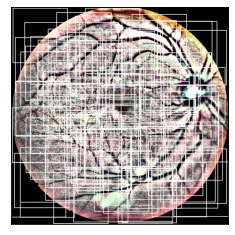

In [ ]:
plt.imshow(imgx)
plt.xticks([])
plt.yticks([])

In [ ]:
main_dir = '/content/drive/MyDrive/CMKL/datasets/IOSTAR/IOSTAR Vessel Segmentation Dataset'
img_folder = 'image'#'image_preprocessed','image'
orig = 1024
output = 256
folder_name = 'patch_grayscale_IOSTAR'
number_patch_per_sbj=100
count_sbj = 0
folder_num = 1
alpha,beta,gamma = 4,-4,128
gridsize=3
count_file_in_folder_num = 0
mean_r,sd_r,mean_g,sd_g,mean_b,sd_b = 121, 75, 50, 35, 17, 11
sd_n=35
mean_n=128
new_config = {'train':[],'validation':[]}
count_ix=0
r_all = []
g_all = []
b_all = []
if folder_name not in os.listdir(main_dir):
    os.mkdir(os.path.join(main_dir,folder_name))
    os.mkdir(os.path.join(main_dir,folder_name,'train'))
    os.mkdir(os.path.join(main_dir,folder_name,'validation'))
    os.mkdir(os.path.join(main_dir,folder_name,'train','1'))
    os.mkdir(os.path.join(main_dir,folder_name,'validation','1'))
for img_file in os.listdir(os.path.join(main_dir,img_folder)):
    if img_file[0:4] != 'STAR':
        continue
    img_name = img_file.split('_')[0]
    print(img_name)
    count_sbj+=1
    img_path = glob.glob(os.path.join(main_dir,img_folder,img_name+'*'))[0]
    lbl_vsl_path = glob.glob(os.path.join(main_dir,'GT',img_name+'*'))[0]
    lbl_od_path = glob.glob(os.path.join(main_dir,'mask_OD',img_name+'*'))[0]
    lbl_msk_path = glob.glob(os.path.join(main_dir,'mask',img_name+'*'))[0]
    msk_area = cv2.imread(lbl_msk_path)

    plot_before = 0
    img,lbl_cmb_all = prepare_image_label(img_path,lbl_vsl_path,lbl_od_path,lbl_msk_path,plot_before)
    enh_img, cdf_hist = clahe_rgb(img,gridsize=3)
    img3 = preprocessing_bengraham(cv2.cvtColor(enh_img,cv2.COLOR_RGB2BGR),alpha,beta,gamma)
    enh_img2, cdf_hist = clahe_rgb(img3,gridsize=3)
    enh_img2[msk_area==0]=0

    # b0,g0,r0 = cv2.split(img)
    # g = g0.copy()
    # ix = np.where(r==255)
    # g=g.astype(np.float64)
    # g[ix]=g[ix]/r[ix]
    # g[ix] = (sd_n/sd_r)*(g[ix]-mean_r+2*sd_r)+mean_n-2*sd_n
    # g=(g*255).astype(np.uint8)

    # clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
    # img = clahe.apply(g)
    # g_bng = preprocessing_bengraham(img,alpha,beta,gamma)
    # g_bng[msk_area==0]=0
    # enh_img2 = g_bng.copy()
    break
    cv2.imwrite(os.path.join(main_dir,'image_preprocessed',img_name+'_grayscale.png'),enh_img2)
    # fig,ax = plt.subplots(1,3)
    # ax[0].imshow(g,cmap='gray')
    # ax[1].imshow(g_bng)
    # ax[2].imshow(img)
    # break
    # if count_sbj >24:
    #   break
    # if count_sbj<=24:
    #     folder_type = 'train'
    # else:
    #     folder_type = 'validation'
    #     if count_ix<1:
    #         folder_num=1
    #         count_file_in_folder_num=0
    #         count_ix+=1
    
    # file_saved_names = {}
    # count_files=0
    # while count_files <= number_patch_per_sbj:

    #     X, y,start_x,start_y,bgrd_ratio = get_sub_volume(enh_img2, lbl_cmb_all,orig_x = orig, orig_y = orig, 
    #                output_x = output, output_y = output)
    #     file_saved_name = img_name+'x_'+f'{start_x}'+'y_'+f'{start_y}_shape'+f'{output}'+'.h5'
    #     try:
    #         file_saved_names[file_saved_name]+=1
    #         print('hey')
    #         continue
    #     except:
    #         file_saved_names.update({file_saved_name:1})
            
    #         if count_file_in_folder_num>=40:
    #             folder_num+=1
    #             os.mkdir(os.path.join(main_dir,folder_name,folder_type,str(folder_num)))
    #             count_file_in_folder_num=0
            
            
    #         file = h5py.File(os.path.join(main_dir,folder_name,folder_type,str(folder_num),file_saved_name), "w")
    #         new_config[folder_type].append(os.path.join(folder_name,folder_type,str(folder_num),file_saved_name))
    #         file.create_dataset(
    #                 "x", np.shape(X), h5py.h5t.STD_U8BE, data=X
    #             )
    #         file.create_dataset(
    #                 "y", np.shape(y), h5py.h5t.STD_U8BE, data=y
    #             )
    #         file.close()
    #         count_file_in_folder_num+=1
    #         count_files+=1
#     break

STAR 05


(array([1267073.,  501794.,  377746.,  235267.,  194531.,  197911.,
         235533.,   92338.,   33556.,    9979.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

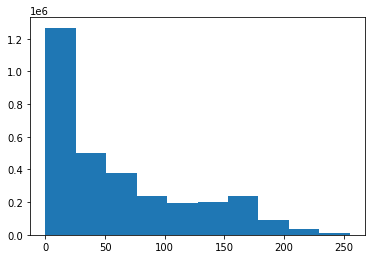

In [ ]:
plt.hist(img.flatten())

[]

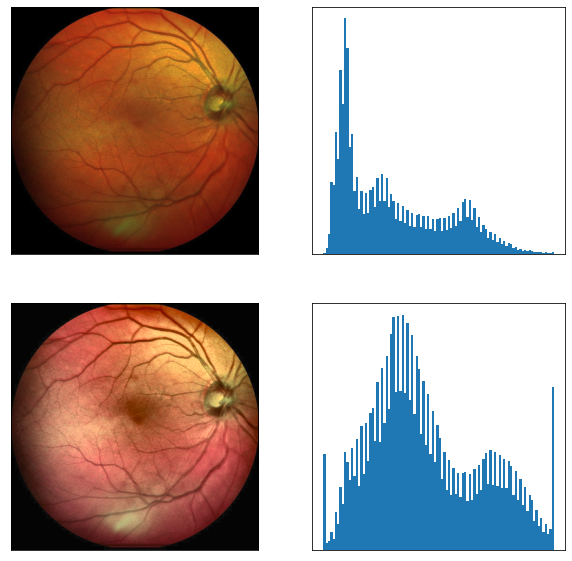

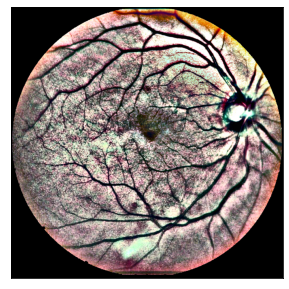

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0][0].imshow(img)
ax[0][1].hist(img[msk_area!=0].flatten(),100)
# ax[0][1].plot(img[msk_area!=0].flatten().cumsum())
ax[1][0].imshow(enh_img)
ax[1][1].hist(enh_img[msk_area!=0].flatten(),100)
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[1][0].set_xticks([])
ax[1][0].set_yticks([])
ax[1][1].set_xticks([])
ax[1][1].set_yticks([])
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(enh_img2)
ax.set_xticks([])
ax.set_yticks([])

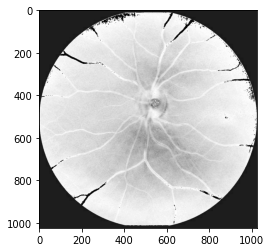

In [ ]:
plt.imshow(gx,cmap='gray')

In [ ]:
with open(os.path.join(main_dir,'config_processed_'+folder_name+'.json'), 'w') as json_file:
    json.dump(new_config, json_file)

In [ ]:
type(r_all)

NoneType

### Check class imbalance

In [ ]:
main_dir = 'G:\My Drive\CMKL\datasets\IOSTAR\IOSTAR Vessel Segmentation Dataset'
labels_ratio = {'name_file':[],'od':[],'vs':[],'fl':[]}
with open(os.path.join(main_dir,'config_processed.json'), 'r') as json_file:
    config = json.load(json_file)
    
    
output=256
output_x = output
output_y = output
output_z = 3
images = []
# for fl in os.listdir(os.path.join(main_dir,'patches')):
cnt=0
for fl in config['train']:
#     if fl[0:4] != 'STAR':
#         continue
#     print(fl)
    with h5py.File(os.path.join(main_dir,'patches_preprocessed',fl), 'r') as f:
        x_r = np.array(f.get("x"))
        y_r = np.array(f.get("y"))
#     visualize_patch(x_r,y_r[1])
    ratio_od = np.sum(y_r[0,:,:,:])
    ratio_vs = np.sum(y_r[1,:,:,:])
    ratio_fl = np.sum(y_r[2,:,:,:])
    labels_ratio['od'].append(ratio_od)
    labels_ratio['vs'].append(ratio_vs)
    labels_ratio['fl'].append(ratio_fl)
    labels_ratio['name_file'].append(fl)
    ratios = [ratio_od,ratio_vs,ratio_fl]
    images.append(x_r)
    cnt+=1
    if cnt>=5:
        break
#     if ratio_fl>1:
#         print(ratios,fl)
#     cnt+=1
#     if cnt == 3:
#         break

In [ ]:
x_r.dtype,y_r.dtype

(dtype('uint8'), dtype('uint8'))

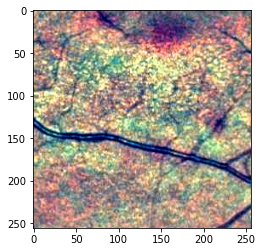

In [ ]:
plt.imshow(x_r)

In [ ]:
np.unique(x_r)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
x_r.shape,y_r.shape,fl

((256, 256, 3), (), 'STAR 38x_306y_238.h5')

In [ ]:
tmp_ratios = labels_ratio.copy()

In [ ]:
total = 0
for i,a in tmp_ratios.items():
    print(i,np.sum(a))
    total+=np.sum(a)
for i,a in tmp_ratios.items():
    print(i,np.sum(a)/total*100)
    

od 209.6731414794922
vs 691.9021606445312
fl 5913.332870483398
od 3.0766832973960687
vs 10.152773054604573
fl 86.77054364799936


In [ ]:
for i,j in labels_ratio.items():
    if i =='name_file':
        continue
    print(i,np.sum(j))

od 42578967
vs 141672408
fl 1218238155


# Preprocessing

In [ ]:
# import albumentations

In [ ]:
import pandas as pd
from albumentations import (Flip,RandomBrightnessContrast,
                            RandomSizedCrop,Cutout,RandomSunFlare,
                            Compose)

In [ ]:
alpha,beta,gamma = 4,-4,128
main_dir = r'G:\My Drive\CMKL\datasets\IOSTAR\IOSTAR Vessel Segmentation Dataset'
img_files = os.listdir(os.path.join(main_dir,'image'))
images = []
count = 0
for img_name in img_files:
    img = cv2.imread(os.path.join(main_dir,'image',img_name))
    img2 = preprocessing_bengraham(img,alpha,beta,gamma)
#     img2 = cv2.cvtColor(img2,cv2.COLOR_RGB2BGR)
#     img_name_new = img_name.split('.')[0]+'_preprocessed.'+img_name.split('.')[1]
#     cv2.imwrite(os.path.join(main_dir,'image_preprocessed',img_name_new),img2)
    images.append(img2)
    count+=1
    if count>=7:
        break
    

In [ ]:
os.path.join(main_dir,img_name_new)

'G:\\My Drive\\CMKL\\datasets\\IOSTAR\\IOSTAR Vessel Segmentation Dataset\\STAR 09_OSN_preprocessed.jpg'

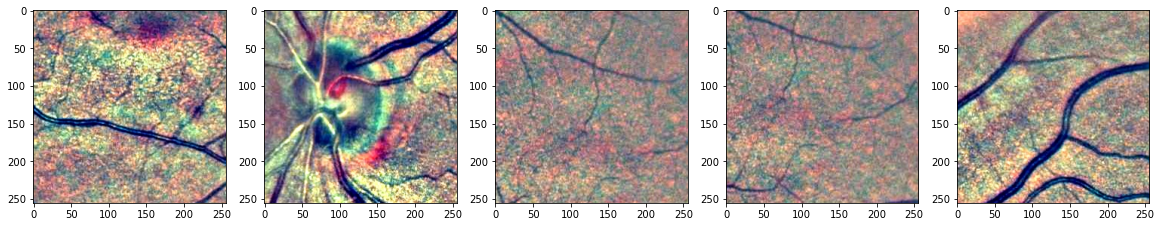

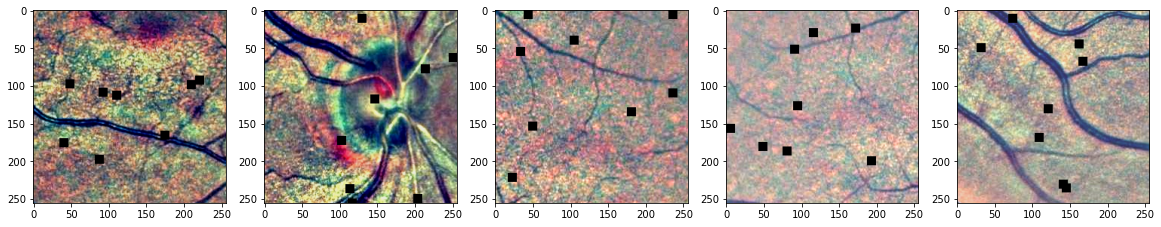

In [ ]:
IMG_SIZE = (256,256)
aug1 = Flip(p=0.8)
aug2 = RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=1)
h_min=np.round(IMG_SIZE[1]*0.72).astype(int) # ระบุว่าจะ crop ไม่น้อยกว่า 72% ของรูปเดิม
h_max= np.round(IMG_SIZE[1]*0.9).astype(int)  # ระบุว่าจะ crop ไม่มากกว่า 90% ของรูปเดิม
# aug3 = RandomSizedCrop((h_min, h_max),IMG_SIZE[1],IMG_SIZE[0], w2h_ratio=IMG_SIZE[0]/IMG_SIZE[1],p=1)
max_hole_size = int(IMG_SIZE[1]/20) # กำหนดขนาดของจุดที่เราจะลบออก
aug4 = Cutout(p=1,max_h_size=max_hole_size,max_w_size=max_hole_size,num_holes=8 )
# aug_sun = RandomSunFlare(src_radius=max_hole_size*2,num_flare_circles_lower=10,num_flare_circles_upper=20,p=1)
# aug5 = Compose([aug_sun,aug_sun,aug_sun],p=1)
aug6 = Compose([aug1,aug2,aug4])
augmented_images = batch_apply_augment(aug6,images)

In [ ]:
np.unique(augmented_images[0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

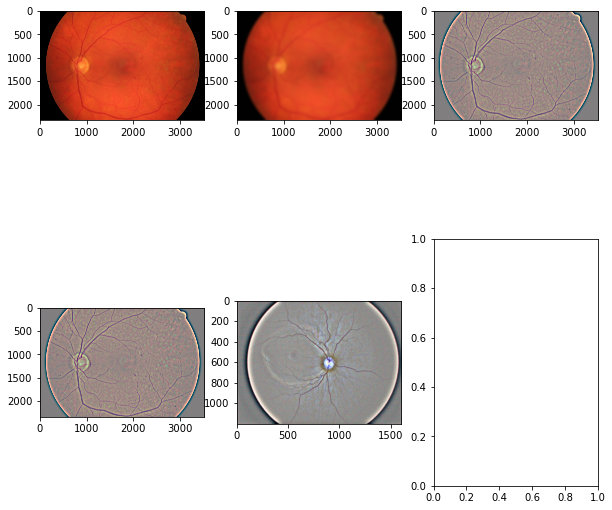

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(10,10))
ax[0][0].imshow(imgx)
img2 = cv2.GaussianBlur(imgx,(0,0),27)
ax[0][1].imshow(img2)
img3 = cv2.addWeighted(imgx,4,img2,-4,128)
ax[0][2].imshow(img3)
img4 = cv2.addWeighted(imgx,4,img2,-4,128)
ax[1][0].imshow(img4)
img5x = cv2.cvtColor(img4,cv2.COLOR_RGB2GRAY)
ax[1][1].imshow(img5,cmap='gray')

In [ ]:
img_path = r'/Volumes/GoogleDrive/My Drive/CMKL/datasets/quality/train/good'
img_name = os.listdir(img_path)[3]
img = cv2.imread(os.path.join(img_path,img_name))
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_name

'STAR 01_OSC.jpg'

In [ ]:
def plot_fig_hist(im1,im2):
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    ax[0][0].imshow(cv2.cvtColor(im1,cv2.COLOR_BGR2RGB))
    ax[0][1].imshow(cv2.cvtColor(im2,cv2.COLOR_BGR2RGB))
    ax[1][0].hist(im1.flatten(),256,[0,256],color='r')
    ax[1][1].hist(im2.flatten(),256,[0,256],color='r')

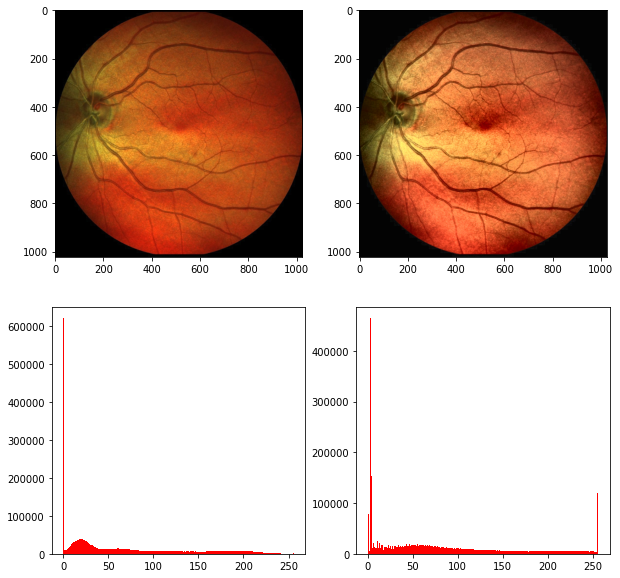

In [ ]:
enhanced_hist, cdf_hist = clahe_rgb(img,gridsize=3)
plot_fig_hist(img,enhanced_hist)

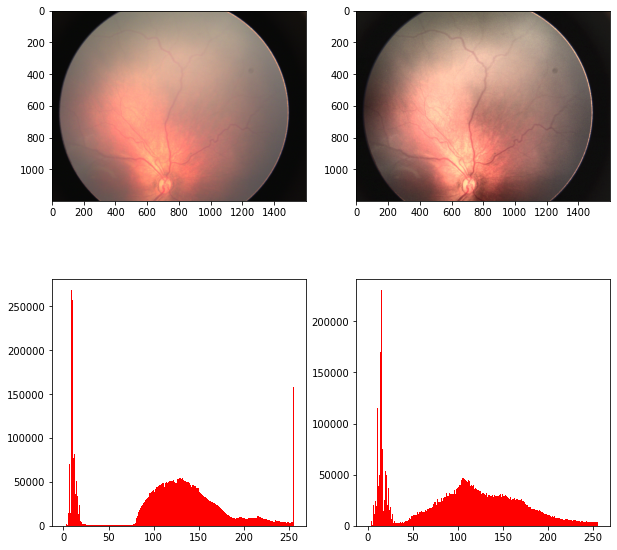

In [ ]:
enhanced_hist, cdf_hist = clahe_rgb(img,gridsize=3)
plot_fig_hist(img,enhanced_hist)

In [ ]:
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave

In [ ]:
def convert_to_uint8(im0):
    im1 = im0.copy()
    im1x = im1/im1.max()
    im1x = 255*im1x
    im1x = im1x.astype(np.uint8)
    return im1x

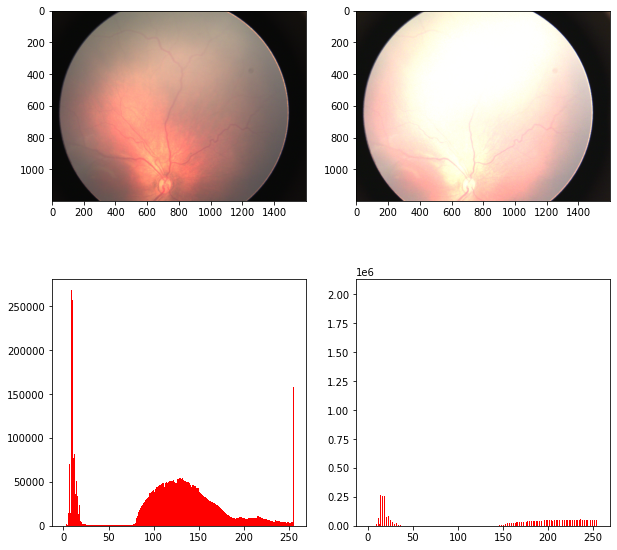

In [ ]:
yen_thr = threshold_yen(img)
img2 = convert_to_uint8(rescale_intensity(img,(0, yen_thr), (0, 255)))
plot_fig_hist(img,img2)

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(20,10))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
ax[0][0].imshow(img)
img2 = cv2.GaussianBlur(img,(0,0),27)
ax[0][1].imshow(img2)
img3 = cv2.addWeighted(img,4,img2,-4,128)
ax[0][2].imshow(img3)
img4 = cv2.addWeighted(img,4,img2,-4,128)
ax[0][3].imshow(img4)

kernel_sharpen_3 = np.array([[-1,-1,-1,-1,-1],
[-1,2,2,2,-1],
[-1,2,8,2,-1],
[-1,2,2,2,-1],
[-1,-1,-1,-1,-1]]) / 8.0
img5 = cv2.filter2D(img4,-1,kernel_sharpen_3)
ax[1][0].imshow(img5)

img6 = cv2.cvtColor(img4,cv2.COLOR_RGB2GRAY)
ax[1][1].imshow(img6,cmap='gray')
img7 = cv2.cvtColor(img5,cv2.COLOR_RGB2GRAY)
ax[1][2].imshow(img7,cmap='gray')

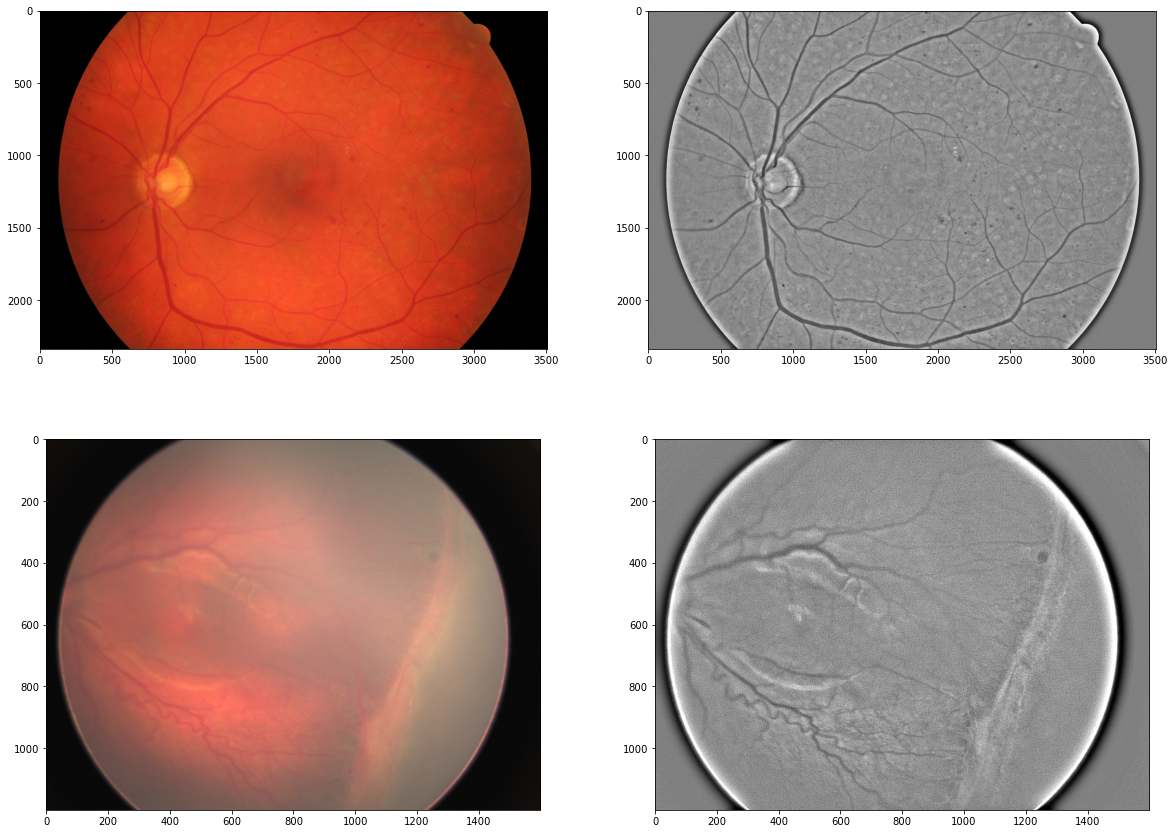

In [ ]:
kernel_sharpen_1 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
output_1 = cv2.filter2D(img, -1, kernel_sharpen_1)
img7 = cv2.filter2D(img4,-1,kernel_sharpen_3)
img7 = cv2.cvtColor(img7,cv2.COLOR_RGB2GRAY)
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(20,15))
ax[0][0].imshow(imgx)
ax[0][1].imshow(img5x,cmap='gray')
ax[1][0].imshow(img)
ax[1][1].imshow(img7,cmap='gray')

#Check read patched files

In [ ]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import json
import shutil

In [ ]:
base_dir = '/content/drive/My Drive/CMKL/datasets/IOSTAR/IOSTAR Vessel Segmentation Dataset' #google drive
all_files = os.listdir(os.path.join(base_dir,'patches_preprocessed'))
print(len(all_files))
with h5py.File(os.path.join(base_dir,'patches_preprocessed','STAR 44x_116y_313_preprocessed.h5'), 'r') as f:
  X = np.array(f.get("x"))
  # remove the background class
  # print(np.array(f.get("y")).shape)
  y = np.array(f.get("y"))

21011


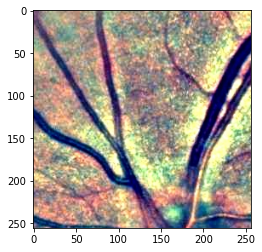

In [ ]:
plt.imshow(X)

In [ ]:
os.mkdir(os.path.join(base_dir,'patches_preprocessed_new'))

In [ ]:
with open(base_dir + "/config_processed.json") as json_file:
    config = json.load(json_file)

In [ ]:
new_config = {'train':[],'validation':[]}
old_dir = os.path.join(base_dir,'patches_preprocessed')
new_dir = os.path.join(base_dir,'patches_preprocessed_new')
for whatset,files in config.items():
  if whatset not in os.listdir(new_dir):
    os.mkdir(os.path.join(new_dir,whatset))
  count_file=1
  count_threshold = 40
  count_folder=1
  if str(count_folder) not in os.listdir(os.path.join(new_dir,whatset)):
    os.mkdir(os.path.join(new_dir,whatset,str(count_folder)))
  for file_name in files:
    if count_file>count_threshold:
      count_folder += 1
      count_file = 1
      os.mkdir(os.path.join(new_dir,whatset,str(count_folder)))
    new_file_name = os.path.join('patches_preprocessed_new',whatset,str(count_folder),file_name)
    old_file_name = os.path.join('patches_preprocessed',file_name)
    shutil.move(os.path.join(base_dir,old_file_name),os.path.join(base_dir,new_file_name))
    new_config[whatset].append(new_file_name)
    count_file +=1

In [ ]:
len(new_config['train']),len(new_config['validation'])

(16807, 4204)

In [ ]:
len(os.listdir(new_dir+'/validation'))

106

In [ ]:
with open(os.path.join(base_dir,'config_processed_new.json'), 'w') as json_file:
    json.dump(new_config, json_file)

In [ ]:
drive.flush_and_unmount()

# HRF Dataset

In [ ]:
import pandas as pd
import pickle

In [ ]:
# main_dir = r'G:\My Drive\CMKL\datasets\HRF'
# df_od = pd.read_excel(os.path.join(main_dir,'optic_disk_centers.xls'),sheet_name='Expert A')

In [ ]:
img_files = os.listdir(os.path.join(main_dir,'images'))
ix = 0
for ix in range(0,len(img_files)):
    if img_files[ix][-3:].lower() != 'jpg':
        continue
    fl_name = img_files[ix]
#     img = cv2.imread(os.path.join(main_dir,'images',img_files[ix]))
    dfi = df_od[df_od['image']==fl_name.split('.')[0]].copy().reset_index(drop=True)
    color = 0
    thickness = -1
    imgx=img.copy()
    msk_od = cv2.imread(os.path.join(main_dir,'mask_bg',img_files[ix].split('.')[0]+'_mask.tif'))
    cv2.circle(msk_od,(dfi.iloc[0,1],dfi.iloc[0,2]),round(0.5*385),color,thickness)
    cv2.imwrite(os.path.join(main_dir,'mask_od',fl_name.split('.')[0]+'.tif'),msk_od)
#     break

In [ ]:
main_dir = '/content/drive/MyDrive/CMKL/datasets/HRF'
img_files = os.listdir(os.path.join(main_dir,'images'))
ix = 0
alpha,beta,gamma = 4,-4,128
orig = 1024
output = 256
folder_name = 'grayscale_HRF'
number_patch_per_sbj=100
count_sbj = 0
folder_num = 1
count_file_in_folder_num = 0
new_config = {'train':[],'validation':[]}
count_ix=0
if folder_name not in os.listdir(main_dir):
    os.mkdir(os.path.join(main_dir,folder_name))
    os.mkdir(os.path.join(main_dir,folder_name,'train'))
    os.mkdir(os.path.join(main_dir,folder_name,'validation'))
    os.mkdir(os.path.join(main_dir,folder_name,'train','1'))
    os.mkdir(os.path.join(main_dir,folder_name,'validation','1'))
for ix in range(0,len(img_files)):
    if img_files[ix][-3:].lower() != 'jpg':
        continue
    img_name = img_files[ix].split('.')[0]
    # if img_name != '12_h':
    #   continue
    count_sbj+=1
    print(img_name)
    img_path = glob.glob(os.path.join(main_dir,'images',img_name+'*'))[0]
    lbl_vsl_path = glob.glob(os.path.join(main_dir,'mask_vs',img_name+'*'))[0]
    lbl_od_path = glob.glob(os.path.join(main_dir,'mask_od',img_name+'*'))[0]
    lbl_msk_path = glob.glob(os.path.join(main_dir,'mask_bg',img_name+'*'))[0]
    msk_area = cv2.imread(lbl_msk_path)
    msk_area = resize_img(msk_area,False,orig)
    plot_before = 0
    try:
      img,lbl_cmb_all = prepare_image_label(img_path,lbl_vsl_path,lbl_od_path,lbl_msk_path,plot_before)
    except:
      print('error')
    img = resize_img(img,False,orig)
    lbl_cmb_all = resize_img(lbl_cmb_all,False,orig)
    # enh_img, cdf_hist = clahe_rgb(img,gridsize=3)
    # img3 = preprocessing_bengraham(cv2.cvtColor(enh_img,cv2.COLOR_RGB2BGR),alpha,beta,gamma)
    # enh_img2, cdf_hist = clahe_rgb(img3,gridsize=3)
    # enh_img2[msk_area==0]=0
    
    b0,g0,r0 = cv2.split(img)
    g = g0.copy()
    ix = np.where(r==255)
    g=g.astype(np.float64)
    g[ix]=g[ix]/r[ix]
    g[ix] = (sd_n/sd_r)*(g[ix]-mean_r+2*sd_r)+mean_n-2*sd_n
    g=(g*255).astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
    img = clahe.apply(g)
    g_bng = preprocessing_bengraham(img,alpha,beta,gamma)
    g_bng[msk_area==0]=0
    enh_img2 = g_bng.copy()
    cv2.imwrite(os.path.join(main_dir,'image_preprocessed',img_name+'_grayscale.png'),enh_img2)
    # if count_sbj<=int(np.ceil(0.8*len(img_files))):
    #     folder_type = 'train'
    # else:
    #     folder_type = 'validation'
    #     if count_ix<1:
    #         folder_num=1
    #         count_file_in_folder_num=0
    #         count_ix+=1
    # print(folder_type)
    # file_saved_names = {}
    # count_files=0
    # while count_files <= number_patch_per_sbj:

    #     X, y,start_x,start_y,bgrd_ratio = get_sub_volume(enh_img2, lbl_cmb_all,orig_x = orig, orig_y = orig, 
    #                output_x = output, output_y = output)
    #     file_saved_name = img_name+'x_'+f'{start_x}'+'y_'+f'{start_y}_shape'+f'{output}'+'.h5'
    #     try:
    #         file_saved_names[file_saved_name]+=1
    #         print('hey')
    #         continue
    #     except:
    #         file_saved_names.update({file_saved_name:1})
            
    #         if count_file_in_folder_num>=40:
    #             folder_num+=1
    #             os.mkdir(os.path.join(main_dir,folder_name,folder_type,str(folder_num)))
    #             count_file_in_folder_num=0
            
            
    #         file = h5py.File(os.path.join(main_dir,folder_name,folder_type,str(folder_num),file_saved_name), "w")
    #         new_config[folder_type].append(os.path.join(folder_name,folder_type,str(folder_num),file_saved_name))
    #         file.create_dataset(
    #                 "x", np.shape(X), h5py.h5t.STD_U8BE, data=X
    #             )
    #         file.create_dataset(
    #                 "y", np.shape(y), h5py.h5t.STD_U8BE, data=y
    #             )
    #         file.close()
    #         count_file_in_folder_num+=1
    #         count_files+=1
    
    # break

14_dr
15_dr
10_dr
13_dr
12_dr
09_dr
11_dr
07_dr
08_dr
06_dr
04_dr
05_dr
02_dr
03_dr
01_dr
14_g
12_g
15_g
13_g
11_g
10_g
09_g
08_g
06_g
07_g
04_g
05_g
03_g
01_g
02_g
12_h
13_h
15_h
14_h
09_h
07_h
08_h
10_h
11_h
04_h
06_h
05_h
03_h
02_h
01_h


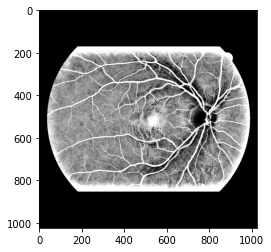

In [ ]:
plt.imshow(enh_img2)

In [ ]:
with open(os.path.join(main_dir,'config_processed_'+folder_name+'.json'), 'w') as json_file:
    json.dump(new_config, json_file)

In [ ]:
os.path.join(main_dir,'config_processed_'+folder_name+'.json')

'/content/drive/MyDrive/CMKL/datasets/HRF/config_processed_image_patch_bgraham_clahe_with_bg_HRF.json'

In [ ]:
main_dir = '/content/drive/MyDrive/CMKL/datasets/HRF'
folder_name = 'image_patch_bgraham_clahe_with_bg_HRF'
with open(os.path.join(main_dir,'config_processed_'+folder_name+'.json'), 'rb') as json_file:
    config = json.load(json_file)

In [ ]:
len(config['validation'])

0

(array([7326910.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  858434.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

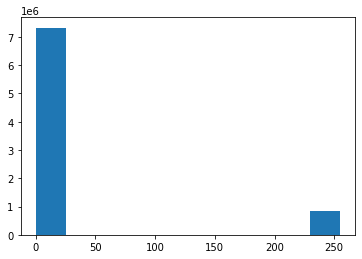

In [ ]:
plt.hist(blackAndWhiteImage.flatten())

(array([2.1979557e+07, 5.0400000e+02, 2.6400000e+02, 1.9800000e+02,
        2.0700000e+02, 3.8700000e+02, 2.8200000e+02, 3.5100000e+02,
        5.1300000e+02, 2.5737690e+06]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

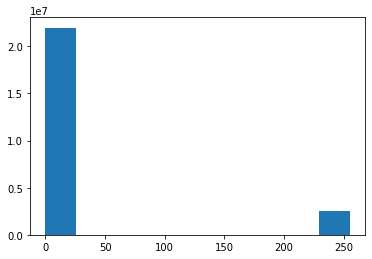

In [ ]:
plt.hist(lbl_vsl.flatten())

In [ ]:
img,lbl_cmb_all = prepare_image_label(img_path,lbl_vsl_path,lbl_od_path,lbl_msk_path,plot_before)

(2336, 3504) (2336, 3504) (2336, 3504)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  68  69  70  71  72  74
  75  76  78  79  80  81  82  83  84  86  87  88  90  91  92  93  94  96
  97  99 100 101 102 103 104 105 106 108 109 110 111 112 113 114 115 116
 117 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 142 143 145 146 149 150 151 152 153 154 156 157 158
 159 160 161 163 164 165 166 167 171 172 173 174 175 177 178 179 180 181
 182 183 184 185 186 187 189 190 191 192 195 196 198 200 201 202 203 204
 205 206 207 208 209 211 213 214 215 216 217 218 219 220 221 222 223 225
 227 228 229 230 232 236 238 239 240 242 243 244 249 252 253 254 255] [  0 255] [  0 255]


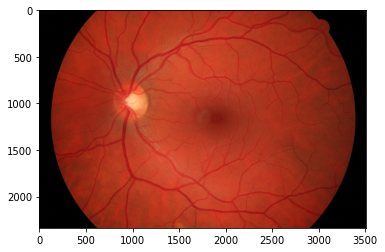

In [ ]:
plt.imshow(img)

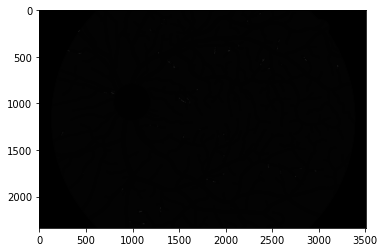

In [ ]:
plt.imshow(lbl_cmb_all)

In [ ]:
# plt.imshow(to_categorical(lbl_cmb_all[:,:,0]))

#CU-ROP Labeled

### Import

In [27]:
work_path = '/content/drive/MyDrive/CMKL/00_colab/02_retina_UNet'
os.chdir(work_path)

In [28]:
!pip install segmentation-models
%env SM_FRAMEWORK=tf.keras
import json
import urllib
import os
import utils
import pandas as pd
from utils import *

env: SM_FRAMEWORK=tf.keras


### file manipulating

In [40]:
def get_mask_ROP(img_name_file,df,write_file=False,nm=None):
  path_labeled = r'/content/drive/MyDrive/CMKL/datasets/CU_ROP_labeled'
  folder_img = r'/content/drive/MyDrive/CMKL/datasets/childrenH/image'
  folder_label = os.path.join(path_labeled,'image')
  all_labels = {'ridge':1,'plus disease':2,'neovasculisation':3}

  id_img_name = df[df['pic_name']==img_name_file].reset_index(drop=True).iloc[0]['id']
  path_lbls = glob.glob(os.path.join(folder_label,id_img_name+'*'))
  if len(path_lbls) == 0:
    print('no labeled image for "'+img_name_file+'".')
    return 0
  img_dir = os.path.join(folder_img,img_name_file)
  img = cv2.imread(img_dir)
  lbl_all = np.zeros_like(img.shape)
  for path_lbl in path_lbls:
    pic_lbl = cv2.imread(path_lbl)
    lbl = path_lbl.split('/')[-1].split('_')[1]
    pic_lbl[pic_lbl==255]=all_labels[lbl]
    lbl_all = cv2.bitwise_or(lbl_all,pic_lbl)
  lbl_all = lbl_all[:,:,0]
  lbl_all = resize_img(lbl_all,desired_size=1024)
  img = resize_img(img,desired_size=1024)
  if write_file:
    cv2.imwrite(os.path.join(path_labeled,'raw','raw_'+nm+'.png'),img)
    cv2.imwrite(os.path.join(path_labeled,'label','label_'+nm+'.png'),lbl_all)

  return img,lbl_all

In [74]:
path_labeled = r'/content/drive/MyDrive/CMKL/datasets/CU_ROP_labeled'
df = pd.read_csv(os.path.join(path_labeled,'note.csv'))

In [113]:
# img_count=1
# df['new_name']='---'
# write_file=1
# for nm_pic in df['pic_name'].unique():
#   print(nm_pic)
#   img_new_name = 'IMG'+str(img_count).zfill(2)
#   img,lbl = get_mask_ROP(nm_pic,df,write_file=write_file,nm=img_new_name)
#   df.loc[df[(df['pic_name']==nm_pic)].index,'new_name']=img_new_name
#   img_count+=1
#   # break
# df.to_csv(os.path.join(path_labeled,'new_note.csv'))

In [80]:
# plt.imshow(lbl)

In [90]:
img_files = os.listdir(os.path.join(path_labeled,'raw'))
img_files = [i for i in img_files if 'raw' in i]

In [111]:
np.ceil(0.8*len(img_files))

21.0

In [114]:
os.getcwd()

'/content/drive/My Drive/CMKL/00_colab/02_retina_UNet'

In [130]:
main_dir = '/content/drive/MyDrive/CMKL/datasets/image_patches'
number_patch_per_sbj=300
count_sbj = 0
folder_num = 1
count_file_in_folder_num = 0
new_config = {'train':[],'validation':[]}
count_ix=0
orig = 1024
output = 256
folder_name = 'image_patches_CU_ROP_Labeled'
if folder_name not in os.listdir(main_dir):
    os.mkdir(os.path.join(main_dir,folder_name))
    os.mkdir(os.path.join(main_dir,folder_name,'train'))
    os.mkdir(os.path.join(main_dir,folder_name,'validation'))
    os.mkdir(os.path.join(main_dir,folder_name,'train','1'))
    os.mkdir(os.path.join(main_dir,folder_name,'validation','1'))
for fl in img_files:
  img_name = fl.split('_')[-1].split('.')[0]
  img = cv2.imread(os.path.join(path_labeled,'raw',fl))
  lbl = cv2.imread(os.path.join(path_labeled,'label','label_'+img_name+'.png'))
  count_sbj+=1
  if count_sbj<=int(np.ceil(0.8*len(img_files))):
      folder_type = 'train'
  else:
      folder_type = 'validation'
      if count_ix<1:
          folder_num=1
          count_file_in_folder_num=0
          count_ix+=1
  print(folder_type)
  file_saved_names = {}
  count_files=0
  while count_files <= number_patch_per_sbj:

      X, y,start_x,start_y,bgrd_ratio = get_sub_volume(img, lbl,orig_x = orig, orig_y = orig, 
                  output_x = output, output_y = output)
      file_saved_name = img_name+'x_'+f'{start_x}'+'y_'+f'{start_y}_shape'+f'{output}'+'.h5'
      try:
          file_saved_names[file_saved_name]+=1
          print('hey')
          continue
      except:
          file_saved_names.update({file_saved_name:1})
          
          if count_file_in_folder_num>=40:
              folder_num+=1
              os.mkdir(os.path.join(main_dir,folder_name,folder_type,str(folder_num)))
              count_file_in_folder_num=0
          
          
          file = h5py.File(os.path.join(main_dir,folder_name,folder_type,str(folder_num),file_saved_name), "w")
          new_config[folder_type].append(os.path.join(folder_name,folder_type,str(folder_num),file_saved_name))
          file.create_dataset(
                  "x", np.shape(X), h5py.h5t.STD_U8BE, data=X
              )
          file.create_dataset(
                  "y", np.shape(y), h5py.h5t.STD_U8BE, data=y
              )
          file.close()
          count_file_in_folder_num+=1
          count_files+=1

  # if count_sbj == 2:
  #   break

train
hey
train
train
train
train
hey
train
train
train
train
train
train
train
train
train
train
hey
train
train
train
train
train
train
hey
validation
validation
validation
validation
validation


In [122]:
y.shape

(4, 256, 256, 3)

In [127]:
# convert_onehot_image(y).shape

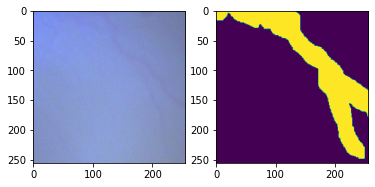

In [128]:
_,ax = plt.subplots(1,2)
ax[0].imshow(X)
ax[1].imshow(convert_onehot_image(np.moveaxis(y,0,-1)[:,:,0,:]))